# Advanced DL and RL: Домашнее задание 1.
<br>

![](logo.png)

Продвинутое машинное обучение: ДЗ 1<br>
Задание: [link](https://docs.google.com/document/d/1u-JiK2opyDeZ2h21nnnmuumyRyYlUL5K3Id7QTWihOU/edit)<br>
Выполнил: **Полянских Сергей**, 2021-10-12

1. [Часть первая, с блекджеком и стратегиями](#Часть-первая,-с-блекджеком-и-стратегиями)
  1. [Очень простая стратегия](#Очень-простая-стратегия)
  2. [Обучение без модели: Q-learning](#Обучение-без-модели:-Q-learning)
  3. [Обучение без модели: on policy MC control](#Обучение-без-модели:-on-policy-MC-control)
2. [Часть вторая, удвоенная](#Часть-вторая,-удвоенная)
3. [Часть третья, в главной роли — Дастин-Хоффман](#Часть-третья,-в-главной-роли-—-Дастин-Хоффман)
4. [Часть четвёртая, опциональная](#Часть-четвёртая,-опциональная)
  1. [Марковская модель](#Марковская-модель)
  2. [Модель с сообщником](#Подключаем-сообщника)
8. [Выводы](#Выводы)

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from consts import *
from utils import *

## Часть первая, с блекджеком и стратегиями

### Очень простая стратегия

In [2]:
class SimpleStrategy(BaseStrategy):    
    @blackjack_gym
    def fit(self, env):
        hit_idx = STATES.query('total<19').index[-1] + 1
        self.pi = np.zeros(len(STATES), dtype=int)
        self.pi[:hit_idx] = 1

In [3]:
strategy = SimpleStrategy()
strategy.fit()
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

Simulation results:
Mean gain: -0.179
Mean steps: 1.741


Мы проиграли, что и неудивительно. Ну что ж, будем знать, на какой бейзлайн ориентироваться в дальнейшем.

Кстати - сразу сдаться еще выгоднее 😎

In [4]:
class GiveUpStrategy(BaseStrategy):
    @blackjack_gym
    def fit(self, env):
        self.pi = np.zeros(len(STATES), dtype=int)

In [5]:
strategy = GiveUpStrategy()
strategy.fit()
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

Simulation results:
Mean gain: -0.171
Mean steps: 1.0


### Обучение без модели: Q learning

In [8]:
class QLearningStrategy(BaseStrategy):
    def __init__(self, n_episodes=10000, alpha=0.05, epsilon=0.1, gamma=1, seed=9):
        self.n_episodes = n_episodes
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.seed = seed
        self.stats = []

    @blackjack_gym
    def fit(self, env, collect_stats=False, n_exp=10000):
        set_seed(self.seed)
        Q = np.zeros((len(STATES), len(ACTIONS)))
        
        for i in tqdm(range(self.n_episodes)):
            Q = self.episode(env=env, Q=Q)
            self.pi = np.argmax(Q, axis=1)
            if collect_stats and (i%10 == 0) and (i <= 2000):
                G_mean, _ = self.evaluate(n_exp=n_exp)
                self.stats.append(G_mean)

    @blackjack_gym
    def episode(self, env, Q):
        state = env.reset()
        s = STATE_TO_IDX[state]
        done = False

        while not done:
            pi = np.argmax(Q, axis=1)
            a = np.random.choice(ACTIONS) if random.random() < self.epsilon else pi[s]
            state, reward, done, _ = env.step(a)
            next_s = STATE_TO_IDX[state]
            Q[s, a] = Q[s, a] + self.alpha*(reward + self.gamma*max(Q[next_s]) - Q[s, a])
            s = next_s

        return Q

In [9]:
strategy = QLearningStrategy(n_episodes=10000)
strategy.fit(collect_stats=True, n_exp=50000)
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

100%|██████████| 10000/10000 [05:22<00:00, 30.97it/s] 


Simulation results:
Mean gain: -0.152
Mean steps: 1.669


Результат подрос, хоть и не вывел нас пока в плюс.

Статистика по ходу обучения:

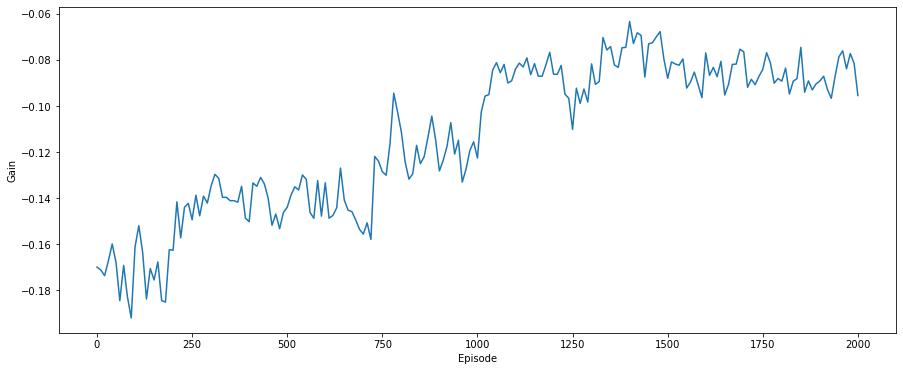

In [10]:
plt.gcf().set_size_inches(15, 6)

stats = strategy.stats
episodes = [10*i for i in range(len(stats))]

plt.plot(episodes, stats)
plt.xlabel('Episode')
plt.ylabel('Gain')
plt.show()

Оптимизируем гиперпараметры по Байесу.

In [ ]:
param_space = [
    skopt.space.Real(0.000001, 0.1, name='alpha'),
    skopt.space.Real(0.001, 0.9, name='epsilon'),
    skopt.space.Real(0.8, 1.0, name='gamma'),
]
static_params = {
    'n_episodes': 10000,
    'seed': 9,
}
opt_params = {
    'n_calls': 1000, 'n_initial_points': 100, 'random_state': 9, 'n_jobs': -1
}

set_seed(9)
results = run_optimization(param_space, static_params, opt_params, QLearningStrategy)

In [12]:
print('Optimization results:')
print('Mean Gain:', round(-results['fun'], 3))
print('  alpha:  ', results['x'][0])
print('  epsilon:', results['x'][1])
print('  gamma:  ', results['x'][2])

Optimization results:
Mean Gain: -0.034
  alpha:   0.0054156332996987315
  epsilon: 0.867072897389788
  gamma:   0.9741906275314811


Результат значительно улучшился. Но все равно пока не в плюсе.

### Обучение без модели: on policy MC control 

In [15]:
class MonteCarloControlStrategy(BaseStrategy):
    def __init__(self, n_init=1000, n_episodes=10000, epsilon=0.1, gamma=1, seed=None):
        self.n_init = n_init
        self.n_episodes = n_episodes
        self.epsilon = epsilon
        self.gamma = gamma
        self.seed = seed
        self.stats = []

    @blackjack_gym
    def fit(self, env, collect_stats=False, n_exp=10000):
        set_seed(self.seed)
        
        R = [[[] for _ in range(len(ACTIONS))] for _ in range(len(STATES))]
        R_all = [[[] for _ in range(len(ACTIONS))] for _ in range(len(STATES))]
        Q = get_random_Q()
        
        print('run init...')
        for _ in range(self.n_init):
            R, R_all, Q, pi = self.episode(Q=Q, R=R, R_all=R_all, is_init=True)

        print('run fit...')
        for i in tqdm(range(self.n_episodes)):
            R, R_all, Q, pi = self.episode(Q=Q, R=R, R_all=R_all, is_init=False)
            self.pi = pi
            if collect_stats and (i%10 == 0) and (i <= 2000):
                G_mean, _ = self.evaluate(n_exp=n_exp)
                self.stats.append(G_mean)
        

    @blackjack_gym
    def episode(self, env, Q, R, R_all, is_init):
        pi = np.argmax(Q, axis=1)
        states, actions, rewards = self.run_episode_actions(env=env, pi=pi)
        R, R_all = self.update_returns_actions(R, states, actions, rewards, R_all=R_all)
        if not is_init:
            Q = get_Q_by_R(R, Q_default=Q)
            
        pi = np.argmax(Q, axis=1)

        return R, R_all, Q, pi

    def run_episode_actions(self, env, pi):
        state = env.reset()
        s = STATE_TO_IDX[state]
        
        next_action = pi[s] if np.random.rand() > self.epsilon else np.random.randint(len(ACTIONS))
        states, actions, rewards = [s], [next_action], [0]
        done = False
        
        while not done:
            state, reward, done, _ = env.step(next_action)
            s = STATE_TO_IDX[state]
            states.append(s)
            next_action = pi[s] if np.random.rand() > self.epsilon else np.random.randint(len(ACTIONS))
            actions.append(next_action)
            rewards.append(reward)

        return states, actions, rewards

    def update_returns_actions(self, R, states, actions, rewards, R_all=None):
        state_first_visit = [-1 for _ in range(len(STATES))]
        for t, state in enumerate(states):
            if state_first_visit[state] == -1:
                state_first_visit[state] = t
             
        if R_all is not None:
            for s in range(len(STATES)):
                for a in range(len(ACTIONS)):
                    R_all[s][a].append(np.nan)
               
        g = 0
        if state_first_visit[states[-1]] == len(states)-1:
            R[states[-1]][actions[-1]].append(g)
            if R_all is not None:
                R_all[states[t]][actions[t]][-1] = g
                
        for t in range(len(states)-2, -1, -1):
            g = g*self.gamma + rewards[t + 1]
            if state_first_visit[states[t]] == t:
                R[states[t]][actions[t]].append(g)
                if R_all is not None:
                    R_all[states[t]][actions[t]][-1] = g
                    
        return R, R_all

In [17]:
strategy = MonteCarloControlStrategy(n_episodes=10000, seed=9)
strategy.fit(collect_stats=True, n_exp=50000)
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

run init...


  0%|          | 0/10000 [00:00<?, ?it/s]

run fit...


100%|██████████| 10000/10000 [06:05<00:00, 27.38it/s]


Simulation results:
Mean gain: -0.082
Mean steps: 1.335


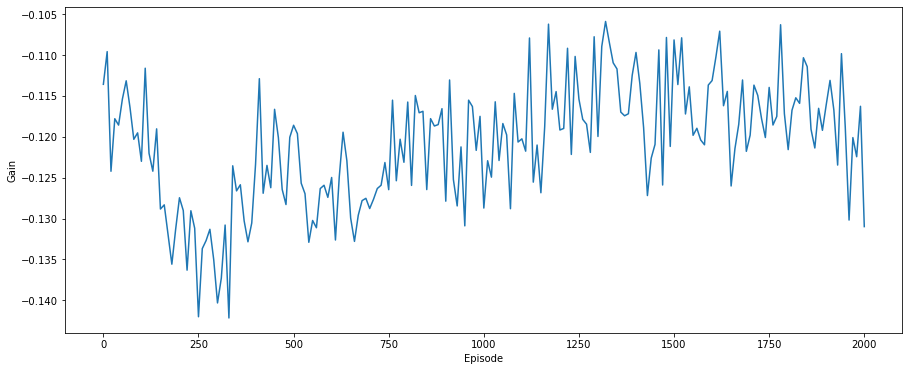

In [18]:
plt.gcf().set_size_inches(15, 6)

stats = strategy.stats
episodes = [10*i for i in range(len(stats))]

plt.plot(episodes, stats)
plt.xlabel('Episode')
plt.ylabel('Gain')
plt.show()

Оптимизация гиперпараметров:

In [ ]:
param_space = [
    skopt.space.Real(0.001, 0.95, name='epsilon'),
    skopt.space.Real(0.8, 1.0, name='gamma'),
]
static_params = {
    'n_init': 100,
    'n_episodes': 5000,
    'seed': 9,
}
opt_params = {
    'n_calls': 300, 'n_initial_points': 50, 'random_state': 9, 'n_jobs': -1
}

set_seed(9)
results = run_optimization(param_space, static_params, opt_params, MonteCarloControlStrategy)

In [21]:
print('Optimization results:')
print('Mean Gain:', round(-results['fun'], 3))
print('  alpha:  ', results['x'][0])
print('  epsilon:', results['x'][1])

Optimization results:
Mean Gain: -0.057
  alpha:   0.526393686882335
  epsilon: 0.8673355318560375


В целом, результаты похожие на G-learning. Пока в минусе.

## Часть вторая, удвоенная

В качестве тестовой модели выберем Q-learning. On policy MC реализован выше и дает практически такие же результаты.

In [24]:
class QLearningDoubledStrategy(BaseDoubledStrategy):
    def __init__(self, n_episodes=10000, alpha=0.05, epsilon=0.1, gamma=1, seed=9):
        self.n_episodes = n_episodes
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.seed = seed
        self.stats = []

    @doubled_blackjack_gym
    def fit(self, env, collect_stats=False, n_exp=10000):
        set_seed(self.seed)
        Q = np.zeros((len(STATES), len(DOUBLED_ACTIONS)))
        
        for i in tqdm(range(self.n_episodes)):
            Q = self.episode(env=env, Q=Q)
            self.pi = np.argmax(Q, axis=1)
            if collect_stats and (i%10 == 0) and (i <= 2000):
                G_mean, _ = self.evaluate(n_exp=n_exp)
                self.stats.append(G_mean)

    @doubled_blackjack_gym
    def episode(self, env, Q):
        state = env.reset()
        s = STATE_TO_IDX[state]
        done = False

        while not done:
            pi = np.argmax(Q, axis=1)
            a = np.random.choice(DOUBLED_ACTIONS) if random.random() < self.epsilon else pi[s]
            state, reward, done, _ = env.step(a)
            next_s = STATE_TO_IDX[state]
            Q[s, a] = Q[s, a] + self.alpha*(reward + self.gamma*max(Q[next_s]) - Q[s, a])
            s = next_s

        return Q

In [25]:
strategy = QLearningDoubledStrategy(n_episodes=500000)
strategy.fit(collect_stats=True, n_exp=50000)
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

100%|██████████| 500000/500000 [06:04<00:00, 1372.51it/s] 


Simulation results:
Mean gain: -0.127
Mean steps: 1.367


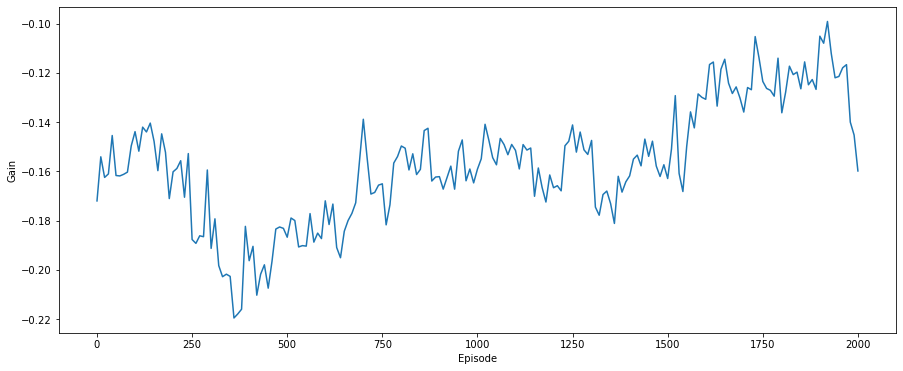

In [26]:
plt.gcf().set_size_inches(15, 6)

stats = strategy.stats
episodes = [10*i for i in range(len(stats))]

plt.plot(episodes, stats)
plt.xlabel('Episode')
plt.ylabel('Gain')
plt.show()

На графике отображены только первые 2к итераций из 500к, поэтому основной тренд не очень виден.

Оптимизируем гиперпараметры по Байесу:

In [ ]:
param_space = [
    skopt.space.Real(0.000001, 0.1, name='alpha'),
    skopt.space.Real(0.001, 0.9, name='epsilon'),
    skopt.space.Real(0.8, 1.0, name='gamma'),
]
static_params = {
    'n_episodes': 10000,
    'seed': 9,
}
opt_params = {
    'n_calls': 1000, 'n_initial_points': 100, 'random_state': 9, 'n_jobs': -1
}

set_seed(9)
results = run_optimization(param_space, static_params, opt_params, QLearningDoubledStrategy)

In [28]:
print('Optimization results:')
print('Mean Gain:', round(-results['fun'], 3))
print('  alpha:  ', results['x'][0])
print('  epsilon:', results['x'][1])
print('  gamma:  ', results['x'][2])

Optimization results:
Mean Gain: -0.035
  alpha:   0.018002526090181954
  epsilon: 0.6624829926389797
  gamma:   0.8542786155659589


## Часть третья, в главной роли — Дастин Хоффман

Будем использовать систему "Плюс-Минус" из [википедии](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA#%D0%9F%D0%BE%D0%B4%D1%81%D1%87%D1%91%D1%82_%D0%BA%D0%B0%D1%80%D1%82). Судя по матожиданиям виигрышей, системы подсчета не сильно отличаются друг от друга.

In [30]:
class QLearningDoubledCountingStrategy(BaseDoubledCountingStrategy):
    def __init__(self, n_episodes=10000, alpha=0.05, epsilon=0.1, gamma=1, seed=9):
        self.n_episodes = n_episodes
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.seed = seed
        self.stats = []

    @doubled_counting_blackjack_gym
    def fit(self, env, collect_stats=False, n_exp=10000):
        set_seed(self.seed)
        Q = np.zeros((len(STATES_COUNTS), len(DOUBLED_ACTIONS)))

        for i in tqdm(range(self.n_episodes)):
            Q = self.episode(env=env, Q=Q)
            self.pi = np.argmax(Q, axis=1)
            if collect_stats and (i%10 == 0) and (i <= 2000):
                G_mean, _ = self.evaluate(n_exp=n_exp)
                self.stats.append(G_mean)

    @doubled_counting_blackjack_gym
    def episode(self, env, Q):
        state = env.reset()
        s = STATE_COUNTS_TO_IDX[state]
        done = False

        while not done:
            pi = np.argmax(Q, axis=1)
            a = np.random.choice(DOUBLED_ACTIONS) if random.random() < self.epsilon else pi[s]
            state, reward, done, _ = env.step(a)
            next_s = STATE_COUNTS_TO_IDX[state]
            Q[s, a] = Q[s, a] + self.alpha*(reward + self.gamma*max(Q[next_s]) - Q[s, a])
            s = next_s

        return Q

In [31]:
strategy = QLearningDoubledCountingStrategy(n_episodes=2000000, alpha=0.0002, epsilon=0.95, gamma=1.0)
strategy.fit(collect_stats=True, n_exp=50000)
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

100%|██████████| 2000000/2000000 [13:00<00:00, 2563.94it/s]


Simulation results:
Mean gain: -0.024
Mean steps: 1.376


Мы подобрались максимально близко, но пока все-таки не выиграли. Попробуем оптимизацию.

In [ ]:
param_space = [
    skopt.space.Real(0.000001, 0.1, name='alpha'),
    skopt.space.Real(0.001, 0.99, name='epsilon'),
    skopt.space.Real(0.8, 1.0, name='gamma'),
]
static_params = {
    'n_episodes': 10000,
    'seed': 9,
}
opt_params = {
    'n_calls': 1000, 'n_initial_points': 100, 'random_state': 9, 'n_jobs': -1
}

set_seed(9)
results = run_optimization(param_space, static_params, opt_params, QLearningDoubledCountingStrategy)

In [34]:
print('Optimization results:')
print('Mean Gain:', round(-results['fun'], 3))
print('  alpha:  ', results['x'][0])
print('  epsilon:', results['x'][1])
print('  gamma:  ', results['x'][2])

Optimization results:
Mean Gain: -0.13
  alpha:   0.034729078210231
  epsilon: 0.10261126356357829
  gamma:   0.8385696471063862


Похужело. Наверное 10000 эпизодов для полноценной оценки занчений функции недостаточно (выше мы использовали 2М). Ну и видимо для выигрыша все-таки нужен сплит.

## Часть четвёртая, опциональная

Сплит реализовать можно, хоть и не совсем тривиально, но мне все-таки интереснее построить модель, пусть только и для простейшего случая из первой части, и она вряд ли окажется выигрышной.

### Марковская модель

Заполним таблицу вероятностей перехода (s, a) -> (s', r). 
Выписать явные формулы, наверное, все-таки ~лень~ довольно сложно, поэтому используем MC семплирование, которое восстановит нужные распределения за нас. Правда есть пара моментов.

Во-первых, надо учесть, что при данном переходе участвуют два источника рандома: неизвестная вторая карта в руке крупье и далее после действия a=0 семплирование из колоды до наполнения руки крупье. Т.е. фактически у нас не пара (s, a), а тройка (s, h, a), где h - неизвестная вторая карта в руке крупье. Ее можно сэмплировать равномерно и результаты усреднять.

Во-вторых, состояние s = (21, \*, 1) может представлять собой еще и is_natural ситуацию, что повлияет на семплирование, ибо мы теперь не можем просто расщепить сумму в руке игрока на любой состав карт - нужно рассмотреть два случая. Соответственно, в этом случае

$$
p(s',r|s,a) = p(s',r|s,a,N)p(N) + p(s',r|s,a,\bar N)p(\bar N),
$$

где событие $N$ состоит в том, что состояние s является is natural. Соответственно этому будем строить наше Монте-Карло для вероятностей перехода, предварительно оценив вероятность $p(N)$. Это может произойти только в самом начале с раздачи, поэтому тут вероятность не поленимся выписать прямо явно

$$
p(N) = 2*(1/13)*(4/13) \approx 0.04734
$$

для бесконечной колоды. Для конечной колоды будет число $2*(4/52)*(16/51) \approx 0.04827$, но у нас судя по env именно первый случай. Его и используем. 

В остальных случаях состояние s можно расщеплять в руку как угодно, это не будет иметь значения для семплирования и продолжения игры. Результат провалилируем на нескольких честно посчитанных вручную значениях, вроде:

$$
p((14, 2, 0), 1 | (4, 2, 0), 1) = 4/13, \quad p((6, 2, 0), 1 | (4, 2, 0), 1) = 1/13
$$

In [35]:
class BellmanStrategy(BaseStrategy):
    def __init__(self, gamma=1.0, probs=None, seed=9):
        self.gamma = gamma
        self.seed = seed
        self.probs = probs
        
    @blackjack_gym
    def fit(self, env):
        V_max = self.compute_V_max()
        pi = self.compute_policy_by_V(V_max)
        self.pi = pi
        
    def compute_V_max(self):
        V = get_random_V()

        n_iter = 0
        while True:
            n_iter += 1
            new_V = np.zeros((len(STATES), len(ACTIONS)))

            for s in range(0, TERMINATE_IDX):
                for a in range(len(ACTIONS)):
                    new_Vsa = 0
                    distr = self.probs[s, a]
                    for s_ in range(0, TERMINATE_IDX):
                        for r_ in range(len(REWARDS)):
                            p_srsa = distr[s_, r_]
                            r = IDX_TO_REWARDS[r_]
                            new_Vsa += p_srsa*(r + self.gamma*V[s_])
                    new_V[s, a] = new_Vsa

            new_V = np.max(new_V, axis=1)

            delta = np.sum((V - new_V) ** 2)
            if delta < 0.001:
                break

            V = new_V
        return V


    def compute_policy_by_V(self, V):
        pi = np.zeros((len(STATES), len(ACTIONS)))

        for s in range(len(STATES)):
            for a in range(len(ACTIONS)):
                distr = probs[s, a]
                pi_sa = 0
                for s_ in range(len(STATES)):
                    for r_ in range(len(REWARDS)):
                        p_srsa = distr[s_, r_]
                        r = IDX_TO_REWARDS[r_]
                        pi_sa += p_srsa*(r + self.gamma*V[s_])
                pi[s, a] = pi_sa

        pi = np.argmax(pi, axis=1)   
        return pi


    @blackjack_gym
    def estimate_probs(self, env, n_samples=10000):
        set_seed(self.seed)

        p_natural = 2*(1/13)*(4/13)
        probs = np.zeros((len(STATES), len(ACTIONS), len(STATES), len(REWARDS)))
        
        for sid in tqdm(IDX_TO_STATE):
            s = IDX_TO_STATE[sid]

            if s[0] > 21:  # bust - terminal state
                probs[sid, :, sid, 1] = 1
                continue

            for a in ACTIONS:
                distr = probs[sid, a]

                for _ in range(n_samples):
                    env.reset()
                    env.dealer[0] = s[1]

                    is_natural = False
                    if (s[0] == 21) and (s[2] == 1):
                        is_natural = np.random.binomial(1, p_natural, size=1)[0]

                    env.player = guess_hand(s, is_natural=is_natural)
                    s_next, r, done, _ = env.step(a)
                    sid_next = STATE_TO_IDX[s_next]
                    rid = REWARDS_TO_IDX[r]
                    distr[sid_next, rid] += 1

        probs = probs / (np.expand_dims(probs.sum(axis=(2,3)), axis=(2,3)) + 0.0000001)
        self.probs = probs
        
        print('Ура! У нас есть вероятности перехода. Можно будить Беллмана.')

        # sanity checks
        assert np.allclose(probs[1,1, 122], [0.0, 4/13, 0.0, 0.0], atol=0.01)
        assert np.allclose(probs[1,1, 41],  [0.0, 1/13, 0.0, 0.0], atol=0.01)
        assert np.allclose(probs[1,1, 51],  [0.0, 1/13, 0.0, 0.0], atol=0.01)
        assert np.allclose(probs[1,1, 61],  [0.0, 1/13, 0.0, 0.0], atol=0.01)
        assert np.allclose(probs[261, 0, 261],  [0., 0.3638, 0.6048, 0.0314], atol=0.01)
        for sid in range(len(STATES)):
            assert [sid] == np.where(probs[sid, 0].sum(axis=1) > 0)[0]

In [41]:
strategy = BellmanStrategy(gamma=0.95)
strategy.estimate_probs(n_samples=50000)
strategy.fit()
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

Simulation results:
Mean gain: -0.03
Mean steps: 1.617


Весьма неплохой результат для обычного блэкджека. Модель действительно полезно иметь.

### Подключаем сообщника

Идея в том, чтобы играть по минимальным ставкам, когда колода "холодная" (счет < 15) и начинать ставить много, когда колода "горячая" (счет >= 15). Судя по фильму "Двадцать одно" одному человеку это реализовать не позволят - для определения степени нагретости колоды потребуется сообщник. Технически это не сильно отличается от обычной игры с удвоением и подсчетом - просто начинаем повышать ставки, когда колода становится "горячей" (выигрыши и проигрыши сообщника естественно считать нашими собственными, раз уж мы работаем в команде).

In [2]:
class QLearningAccomplingStrategy(BaseAccompliceStrategy):
    def __init__(self, n_episodes=10000, alpha=0.05, epsilon=0.1, gamma=1, seed=9):
        self.n_episodes = n_episodes
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.seed = seed
        self.stats = []

    @accomplice_blackjack_gym
    def fit(self, env, collect_stats=False, n_exp=10000):
        set_seed(self.seed)
        Q = np.zeros((len(STATES_COUNTS), len(DOUBLED_ACTIONS)))

        for i in tqdm(range(self.n_episodes)):
            Q = self.episode(env=env, Q=Q)
            self.pi = np.argmax(Q, axis=1)
            if collect_stats and (i%10 == 0) and (i <= 2000):
                G_mean, _ = self.evaluate(n_exp=n_exp)
                self.stats.append(G_mean)

    @accomplice_blackjack_gym
    def episode(self, env, Q):
        state = env.reset()
        s = STATE_COUNTS_TO_IDX[state]
        done = False

        while not done:
            pi = np.argmax(Q, axis=1)
            a = np.random.choice(DOUBLED_ACTIONS) if random.random() < self.epsilon else pi[s]
            state, reward, done, _ = env.step(a)
            next_s = STATE_COUNTS_TO_IDX[state]
            Q[s, a] = Q[s, a] + self.alpha*(reward + self.gamma*max(Q[next_s]) - Q[s, a])
            s = next_s

        return Q

In [3]:
strategy = QLearningAccomplingStrategy(n_episodes=2000000, alpha=0.0002, epsilon=0.95, gamma=1.0)
strategy.fit(collect_stats=True, n_exp=50000)
G_mean, l_mean = strategy.evaluate(n_exp=100000)

print('Simulation results:')
print('Mean gain:', round(G_mean, 3))
print('Mean steps:', round(l_mean, 3))

100%|██████████| 2000000/2000000 [14:15<00:00, 2336.66it/s]


Simulation results:
Mean gain: -0.016
Mean steps: 1.377


In [ ]:
param_space = [
    skopt.space.Real(0.000001, 0.5, name='alpha'),
    skopt.space.Real(0.001, 0.99, name='epsilon'),
    skopt.space.Real(0.8, 1.0, name='gamma'),
]
static_params = {
    'n_episodes': 500000,
    'seed': 9,
}
opt_params = {
    'n_calls': 500, 'n_initial_points': 50, 'random_state': 9, 'n_jobs': -1
}

set_seed(9)
results = run_optimization(param_space, static_params, opt_params, QLearningAccomplingStrategy)

In [6]:
print('Optimization results:')
print('Mean Gain:', round(-results['fun'], 3))
print('  alpha:  ', results['x'][0])
print('  epsilon:', results['x'][1])
print('  gamma:  ', results['x'][2])

Optimization results:
Mean Gain: -0.016
  alpha:   0.0019090750382208391
  epsilon: 0.9887574441177153
  gamma:   0.8086577156581382


Увы, подельник тоже не помог.

## Выводы

- казино обыграть крайне сложно если вообще возможно в обозримом для обычного человека интервале времени
- без split-а, повидимому, выграть у казино вообще невозможно. Меня всегда удивляло, насколько сбалансированны "официальные" азартные игры в этом плане.
- модель (вероятности перехода) повышает общий скор и скорость обучения по сравнению с безмодельными подходами
- Q-learning прост в имплементации, но немного проигрывает MC control
